The purpose of these experiments is to **think about a property of initialization that end up in small error after training**.

For different initializations of $w$, record: 
- average number of matches for each state 
- loss before gradient descent
- loss after gradient descent

<a href='#e1'>Experiment 1</a>: 3-layer MLP, test for low-rank and full-rank matrices.
- 10-3-1 network, 1000 samples, rank 4 covariance, 200 epochs
- 10-3-1 network, 1000 samples, rank 10 covariance, 200 epochs

<a href='#e2'>Experiment 2</a>: Simple MLP with one neuron and two inputs.
- 2-1 network, 1000 samples, rank 2 covariance, 200 epochs, 3D plot of obj
- 3-1 network, 1000 samples, rank 3 covariance, 200 epochs
- 3-1 network, 1000 samples, rank 3 covariance, 1000 epochs
- 10-1 network, 1000 samples, rank 10 covariance, 200 epochs
- 10-1 network, 10000 samples, rank 10 covariance, 200 epochs

<a href='#e3'>Experiment 3</a>: No relu at last layer
- 10-3-1 network (no relu at last layer), 1000 samples, rank 10 covariance, 1000 epochs, fixed weights at last layer
- 10-3-1 network (no relu at last layer), 1000 samples, rank 10 covariance, 1000 epochs

<a href='#e4'>Experiment 4</a>: Do slightly perturbed versions of $w^*$ converge to $w^*$?
- 10-3-1 network, 1000 samples, rank 10 covariance, 100 epochs, initialize with perturbed $w^*$
- 10-3-1 network, 1000 samples, rank 10 covariance, 1000 epochs, initialize with perturbed $w^*$

<a href='#e5'>Experiment 5</a>: Try 2 layer net with 3 input nodes, 1 hidden node. Set $w^*$ to [1 -0.5 0.5], plot the obtained w*’s
- 3-1 network, 1000 samples, rank 10 covariance, 1000 epochs, $w^∗ = [1 \ -0.5 \ 0.5]$, 3D plot of $\hat{w}$

<a href='#e6'>Experiment 6</a>: Fix $w_2$ in $y = w_2 \mbox{relu}(w_1 x)$ case
- 10-3-1 network (no relu at last layer), 1000 samples, rank 10 covariance, 1000 epochs, fix weights from 2nd to 3rd layer to true weights

In [1]:
%load_ext autoreload
%autoreload 2
from __future__ import print_function
import tensorflow as tf
import numpy as np
import os,time,seaborn
import matplotlib.pyplot as plt
import arch,dl_utils,utils

np.set_printoptions(precision=2,suppress=True)
gpu_id = 0

%matplotlib inline

In [2]:
def run_experiment(X,Y,w_true,input_dict,num_sims,build_func=arch.mlp,plot=False,
                   init_perturb_w_true=None,verbose=True,num_epochs=200,
                   initial_weights=None,hs_true=None,seed=0,logdir='./temp/'):
        
    np.random.seed(seed)
    
    if 'h' in input_dict: h = input_dict['h']
    else: h = 1
    p = input_dict['p']
    
    if hs_true is not None: all_prop_matched_states = np.zeros((num_sims,h))
    all_final_loss = np.zeros(num_sims)
    all_final_w_gaps = np.zeros(num_sims)
    all_initial_w_gaps = np.zeros(num_sims)
    all_weights = []
    
    if verbose: start = time.time()
    
    for t in range(num_sims):
        
        savedir = '%sinitialization_%s/'%(logdir,t)

        # Generate w
        if init_perturb_w_true is None:
            weights = {k:np.random.normal(0,1./np.sqrt(np.shape(w_true[k])[0]),
                                          np.shape(w_true[k])) for k in w_true}
        else:
            weights = {k:w_true[k]+np.random.normal(0,(1./np.sqrt(np.shape(w_true[k])[0]))/init_perturb_w_true,
                                          np.shape(w_true[k])) for k in w_true}
            
        if initial_weights is not None:
            for k in initial_weights: weights[k] = initial_weights[k]
         
        if hs_true is not None:
            # Get number of matching states for hidden layer
            hs_ = dl_utils.get_hidden_states(X,input_dict,weights,build_func=build_func)
            all_prop_matched_states[t] = np.mean(hs_ == hs_true,0)

        # Compute loss after gradient descent if weights don't already exist
        if os.path.isdir(savedir):
            w_hat,final_train_loss,final_w_gap = dl_utils.get_train_out(X,Y,w_true,input_dict,
                                                                        savedir,build_func)
            initial_w_gap = dl_utils.compute_w_gap(w_true,weights)
        else:
            tf.reset_default_graph()
            graph = dl_utils.graph_builder_wrapper(input_dict,build_func=build_func)
            _,_,w_hat,_,initial_w_gap,final_train_loss,final_w_gap = \
                    dl_utils.train(X,Y,graph,num_epochs,100,w_true,w_initial=weights,
                                   verbose=verbose,savedir=savedir)
                
        all_final_loss[t] = final_train_loss
        all_final_w_gaps[t] = final_w_gap
        all_initial_w_gaps[t] = initial_w_gap
        all_weights.append(w_hat)

        if plot:
            plt.figure(figsize=(10,5))
            plt.subplot(121)
            plt.plot(training_w_gaps)
            plt.xlabel('epochs')
            plt.ylabel('w gap')
            plt.subplot(122)
            plt.plot(training_losses)
            plt.xlabel('epochs')
            plt.ylabel('training loss')

        if verbose: print('Done with %s/%s (%.2f s elapsed)'%(t+1,num_sims,time.time()-start))
        
    if hs_true is not None: 
        return all_final_loss,all_final_w_gaps,all_initial_w_gaps,all_weights,all_prop_matched_states
    return all_final_loss,all_final_w_gaps,all_initial_w_gaps,all_weights

def set_lims(ax,x,y):
    c = (np.max(x)-np.min(x))*0.1
    ax.set_xlim(np.min(x)-c,np.max(x)+c)
    c = (np.max(y)-np.min(y))*0.1
    ax.set_ylim(np.min(y)-c,np.max(y)+c)
    
def generate_six_plots(all_prop_matched_states,all_final_loss,all_final_w_gaps,all_initial_w_gaps):
    all_prop_matched_states_mean = np.mean(all_prop_matched_states,1)
    f, ((ax1,ax2,ax3),(ax4,ax5,ax6)) = plt.subplots(2,3,figsize=(16,10))
    seaborn.regplot(all_prop_matched_states_mean,all_final_loss,ax=ax1)
    ax1.set(xlabel='proportion of matched states', ylabel='final loss')
    seaborn.regplot(all_initial_w_gaps,all_final_loss,ax=ax2)
    ax2.set(xlabel='initial w gap', ylabel='final loss')
    seaborn.regplot(all_initial_w_gaps,all_final_w_gaps,ax=ax3)
    ax3.set(xlabel='initial w gap', ylabel='final w gap')
    seaborn.regplot(all_prop_matched_states_mean,all_final_w_gaps,ax=ax4)
    ax4.set(xlabel='proportion of matched states', ylabel='final w gap')
    seaborn.regplot(all_initial_w_gaps,all_prop_matched_states_mean,ax=ax5)
    ax5.set(xlabel='initial w gap', ylabel='proportion of matched states')
    seaborn.regplot(all_final_w_gaps,all_final_loss,ax=ax6)
    ax6.set(xlabel='final w gap', ylabel='final loss')
    set_lims(ax6,all_final_w_gaps,all_final_loss)
    
def generate_two_plots(all_final_loss,all_final_w_gaps,all_initial_w_gaps):
    f, (ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
    seaborn.regplot(all_initial_w_gaps,all_final_loss,ax=ax1)
    ax1.set(xlabel='initial w gap', ylabel='final loss')
    seaborn.regplot(all_final_w_gaps,all_final_loss,ax=ax2)
    ax2.set(xlabel='final w gap', ylabel='final loss')
    
def run_exp_and_plot(p=10,N=1000,q=4,h=3,build_func=arch.mlp,num_epochs=100,verbose=True):

    logdir = './temp/p%s_N%s_q%s_h%s_arch%s_numepochs%s/'%(p,N,q,h,build_func.__name__,num_epochs)
    
    input_dict = dict(p=p,h=h)
    X,Y,hs,w = dl_utils.generate_data(N,q,input_dict,seed=0,build_func=build_func,get_hs=True)

    all_final_loss,all_final_w_gaps,all_initial_w_gaps,all_weights,all_prop_matched_states = \
        run_experiment(X,Y,w,input_dict,100,hs_true=hs,build_func=build_func,verbose=verbose,
                       num_epochs=num_epochs,logdir=logdir)

    generate_six_plots(all_prop_matched_states,all_final_loss,all_final_w_gaps,all_initial_w_gaps)

In [3]:
# Simple example to get familiar with code

# parameters
p = 5
N = 100
q = 4
h = 3
build_func = arch.mlp
num_epochs = 100
input_dict = dict(p=p,h=h)
savedir = './temp/example/'

# generate data and weights
X,Y,w = dl_utils.generate_data(N,q,input_dict,seed=0,build_func=build_func)
weights = {k:np.random.normal(0,1./np.sqrt(np.shape(w[k])[0]),np.shape(w[k])) for k in w}

# train weights (saved at './temp/example/')
tf.reset_default_graph()
graph = dl_utils.graph_builder_wrapper(input_dict,build_func=build_func)
_,_,w_hat,_,initial_w_gap,final_train_loss,final_w_gap = \
        dl_utils.train(X,Y,graph,num_epochs,100,w,w_initial=weights,savedir=savedir)
print('final train loss: %.2f'%(final_train_loss))

# reload weights and generated predictions
w_hat,final_train_loss,final_w_gap = dl_utils.get_train_out(X,Y,w,input_dict,
                                                            savedir,build_func)
initial_w_gap = dl_utils.compute_w_gap(w,weights)
print('final train loss (weights reloaded): %.2f'%(final_train_loss))

Epoch 100/100 (0.502 s), batch 1.0/1 (0.001 s): loss 0.038, w gap: 5.284
final train loss: 0.04
final train loss (weights reloaded): 0.04


### Experiment 1 <a id='e1'></a>

3-layer MLP, test for low-rank and full-rank matrices.

CPU times: user 7.93 s, sys: 1.02 s, total: 8.96 s
Wall time: 7.69 s


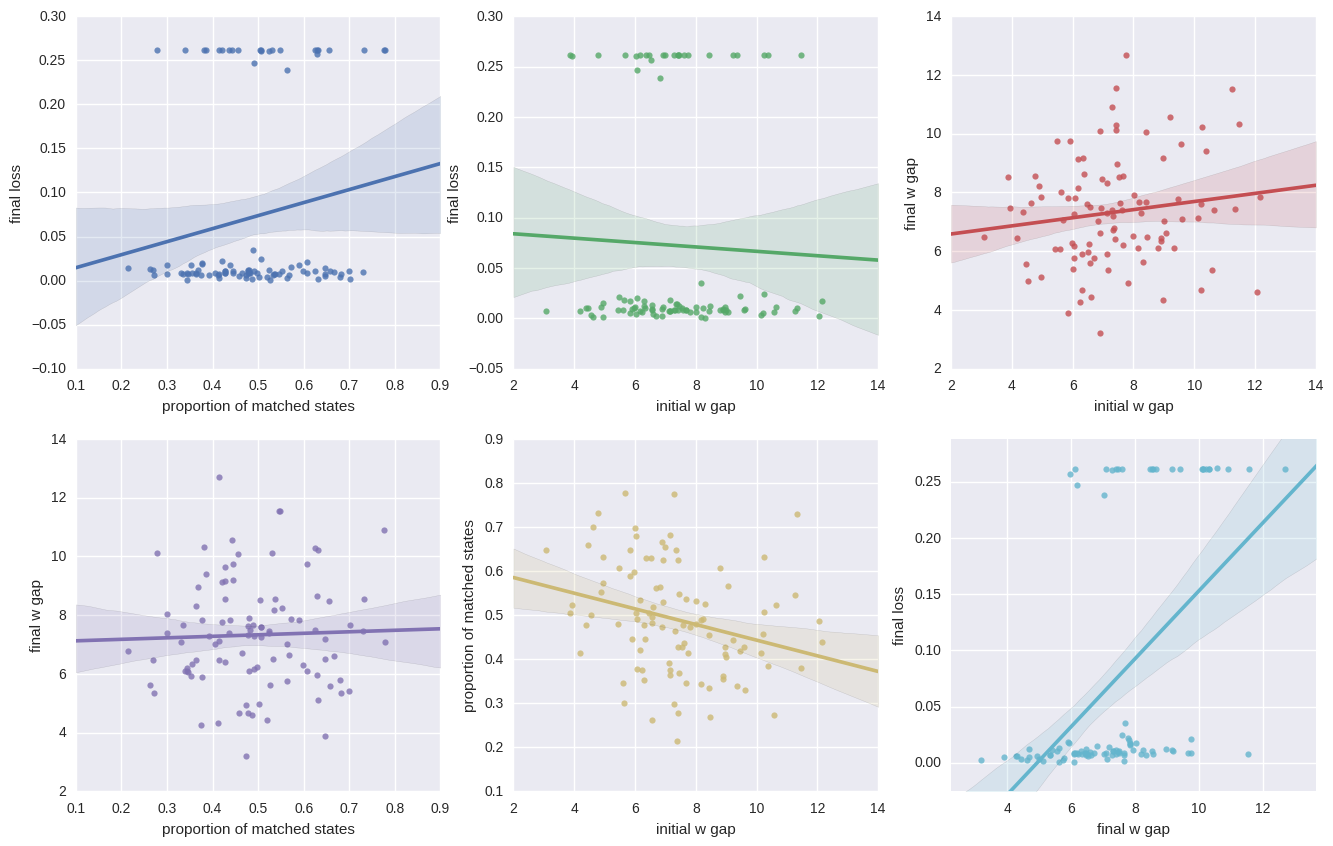

In [4]:
%%time
run_exp_and_plot(p=10,N=1000,q=4,h=3,build_func=arch.mlp,num_epochs=100,verbose=False)

CPU times: user 7.97 s, sys: 960 ms, total: 8.93 s
Wall time: 7.64 s


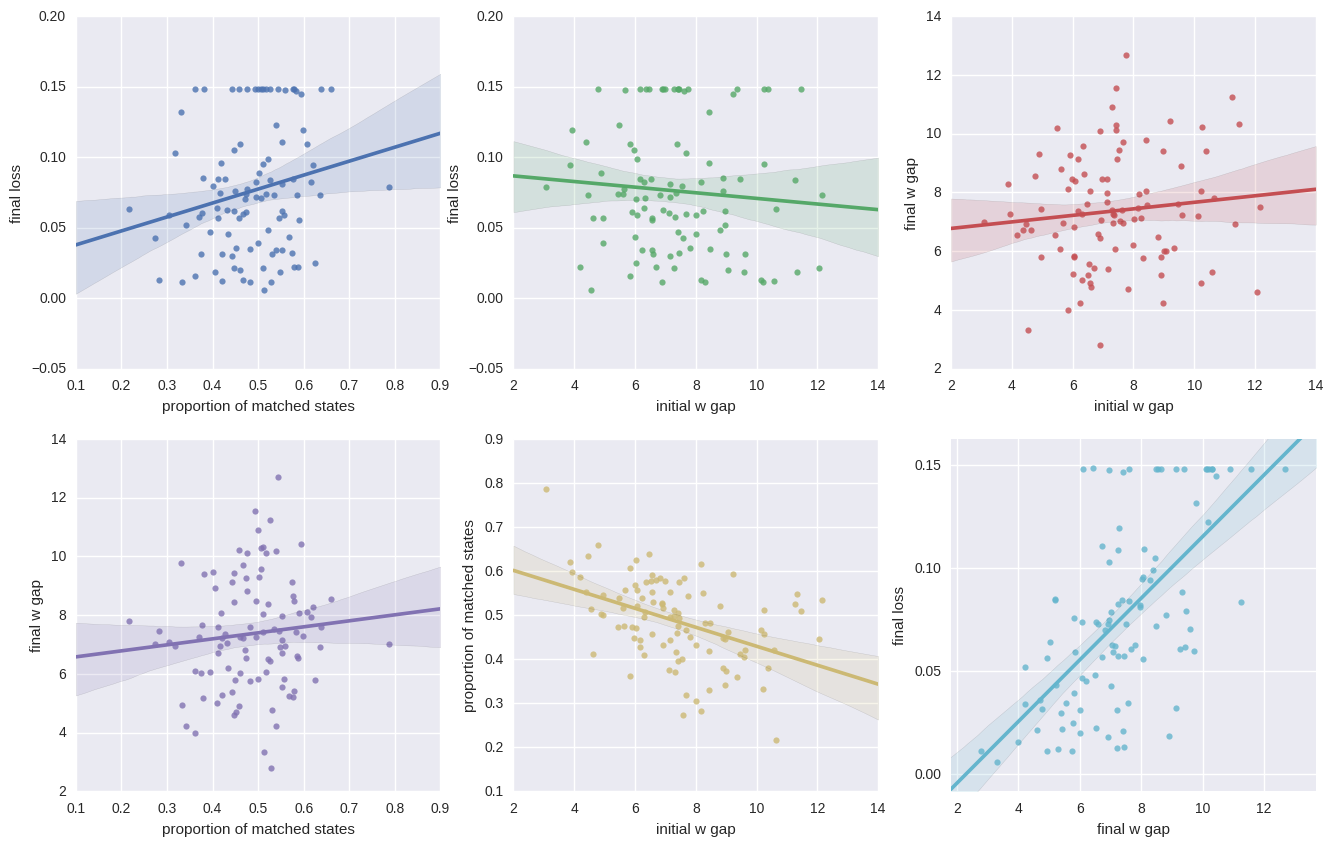

In [5]:
%%time
run_exp_and_plot(p=10,N=1000,q=10,h=3,build_func=arch.mlp,num_epochs=100,verbose=False)

### Experiment 2 <a id='e2'></a>

Simple MLP with one neuron and two inputs. I.e., $y=\sigma (w_1 x_1+w_2 x_2)$.

Test for low dimension (2) and high dimension (10) cases, both with full rank matrices.

CPU times: user 6.26 s, sys: 768 ms, total: 7.03 s
Wall time: 6.03 s


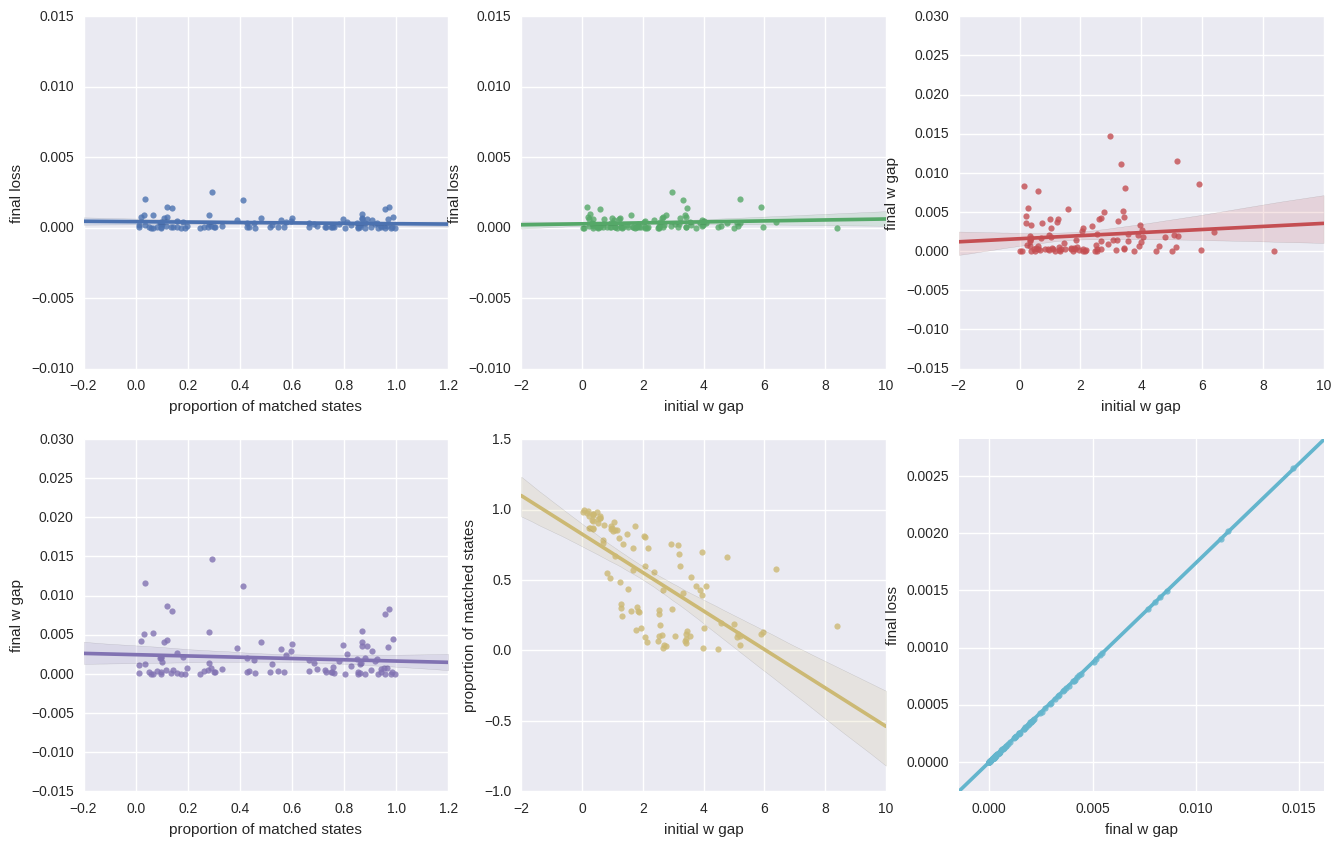

In [6]:
%%time
run_exp_and_plot(p=2,N=1000,q=2,h=1,build_func=arch.mlp_simple,num_epochs=100,verbose=False)

100/100, 100/100 (414.04 s elapsed)


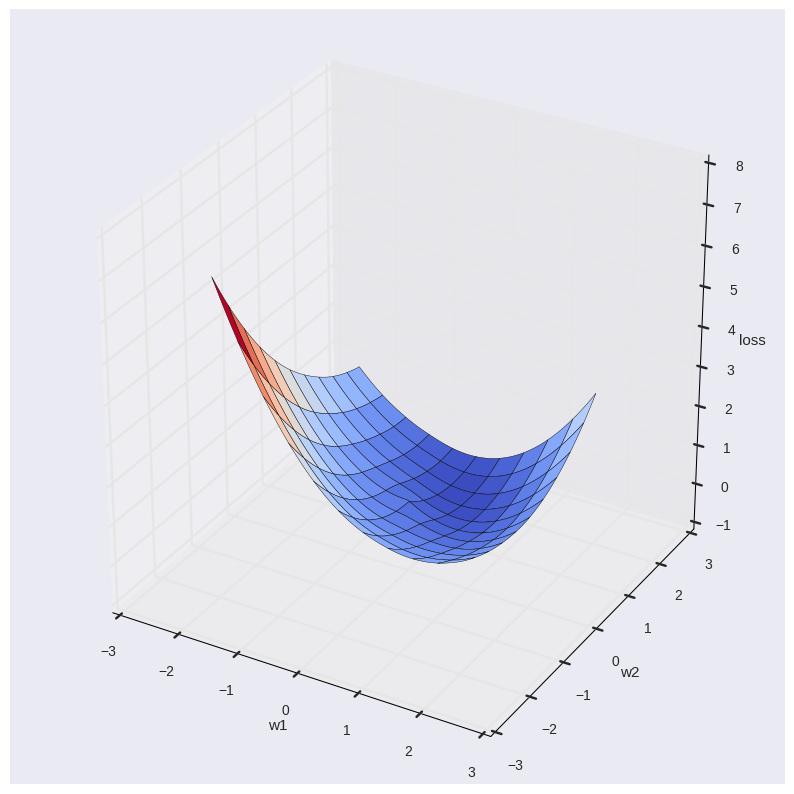

In [9]:
input_dict = dict(p=2,h=1)
X,Y,w = dl_utils.generate_data(1000,2,input_dict,seed=0,build_func=arch.mlp_simple)
all_wi = np.linspace(-2,2,100)
all_wj = np.linspace(-2,2,100)
L = dl_utils.compute_L(X,Y,all_wi,all_wj,input_dict)
utils.plot_L_3D(all_wi,all_wj,L,w['weights'][0],w['weights'][1],0)

CPU times: user 2min 52s, sys: 13.3 s, total: 3min 5s
Wall time: 2min 26s


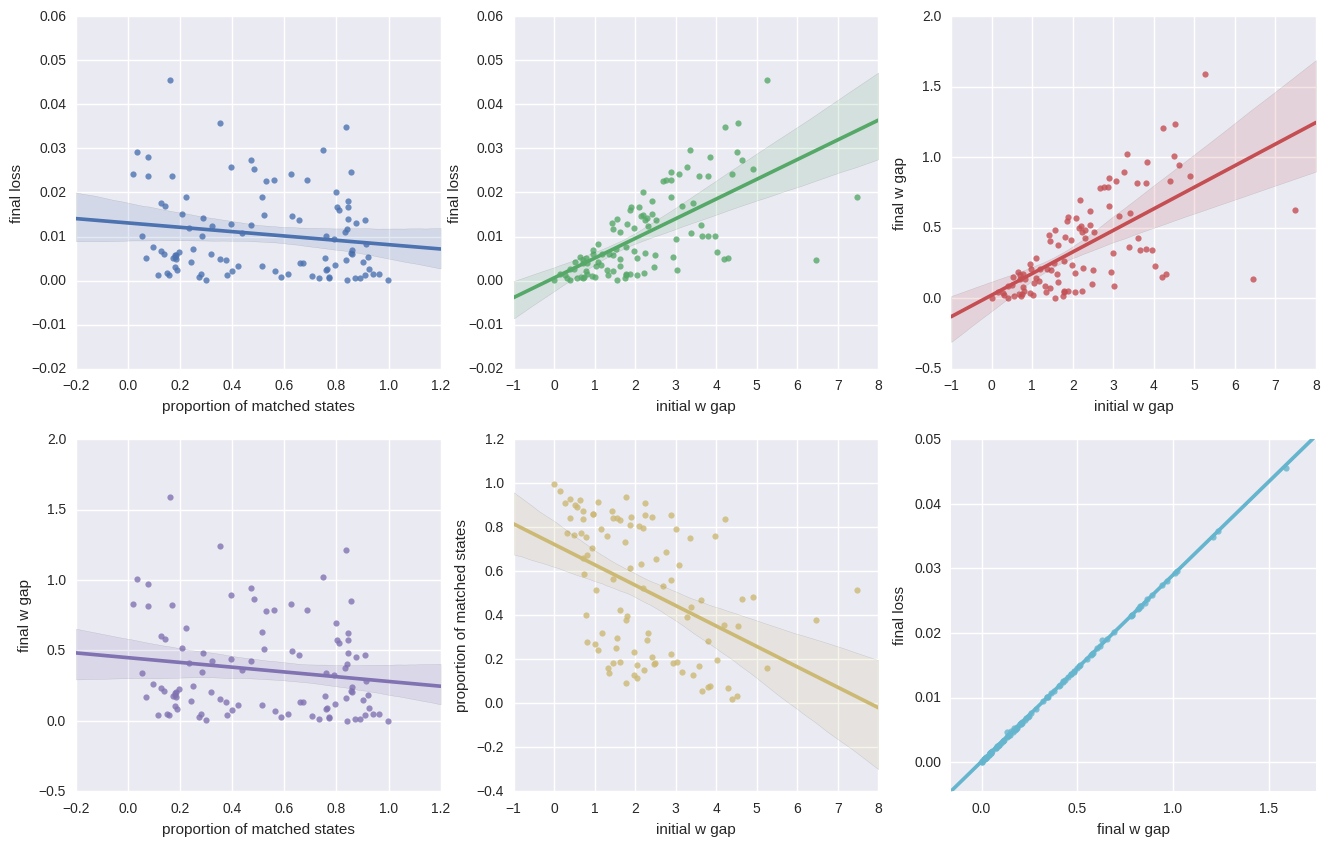

In [10]:
%%time
run_exp_and_plot(p=3,N=1000,q=3,h=1,build_func=arch.mlp_simple,num_epochs=100,verbose=False)

CPU times: user 51min 9s, sys: 1min 56s, total: 53min 6s
Wall time: 43min 2s


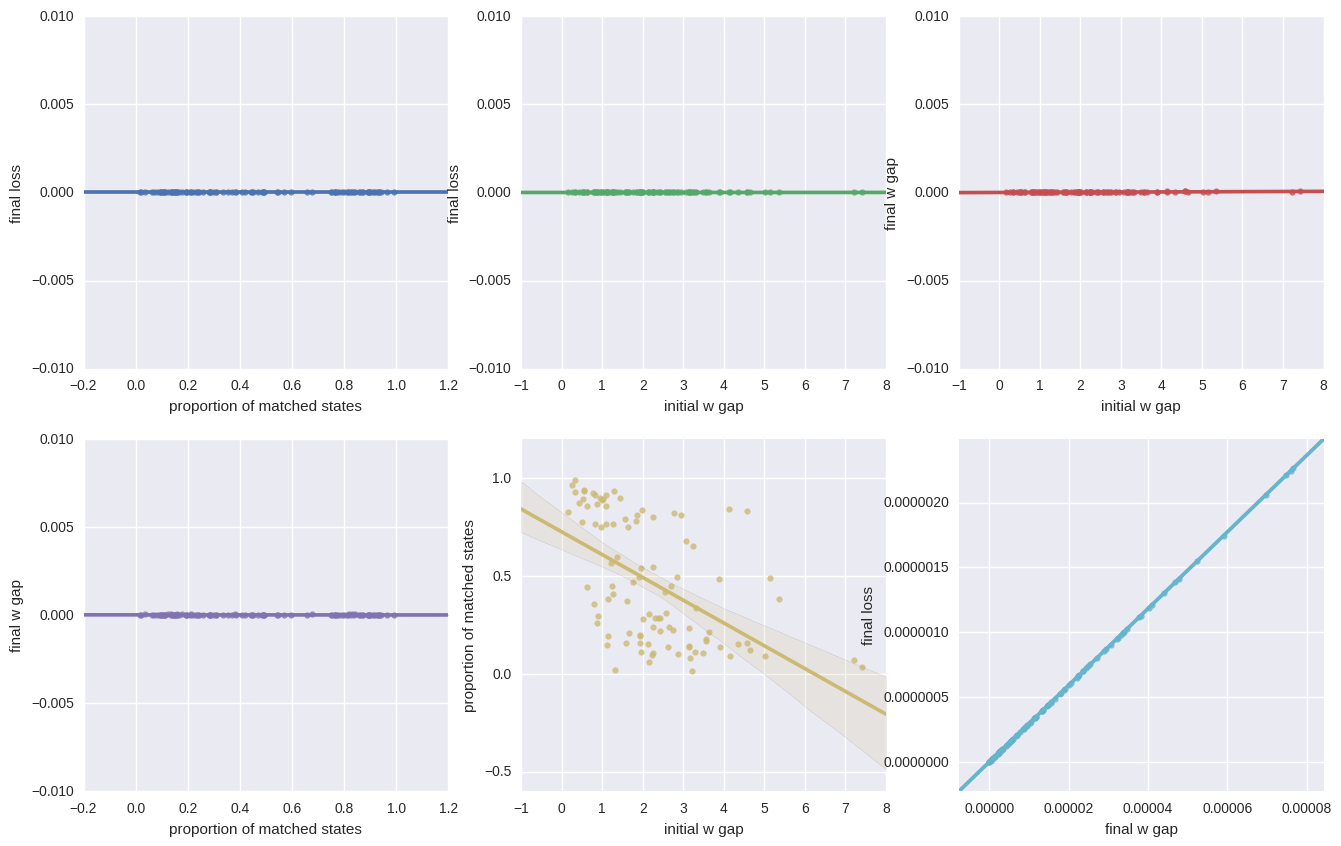

In [11]:
%%time
run_exp_and_plot(p=3,N=1000,q=3,h=1,build_func=arch.mlp_simple,num_epochs=1000,verbose=False)

CPU times: user 2min 52s, sys: 12.7 s, total: 3min 5s
Wall time: 2min 21s


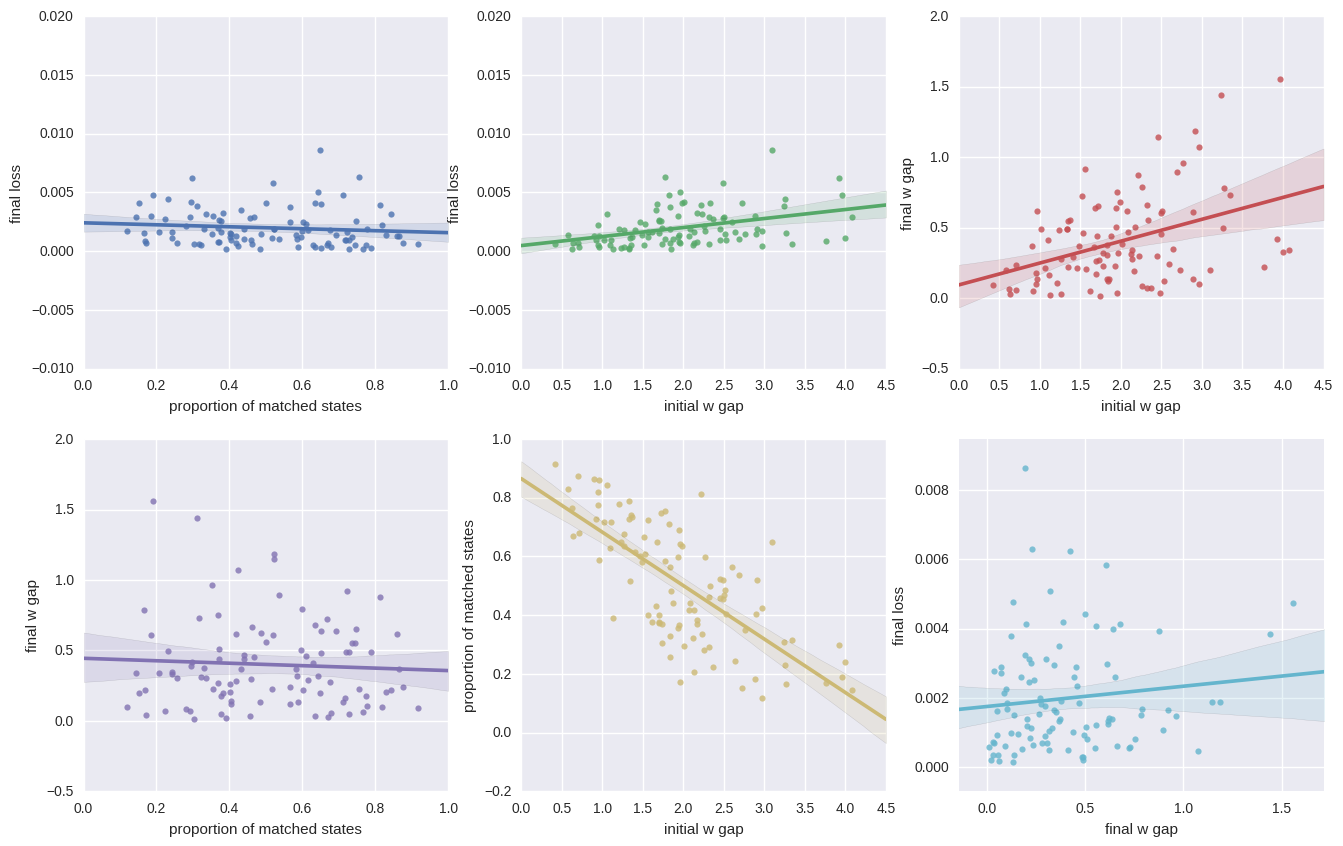

In [12]:
%%time
run_exp_and_plot(p=10,N=1000,q=10,h=1,build_func=arch.mlp_simple,num_epochs=100,verbose=False)

CPU times: user 19min 52s, sys: 1min 40s, total: 21min 32s
Wall time: 12min 38s


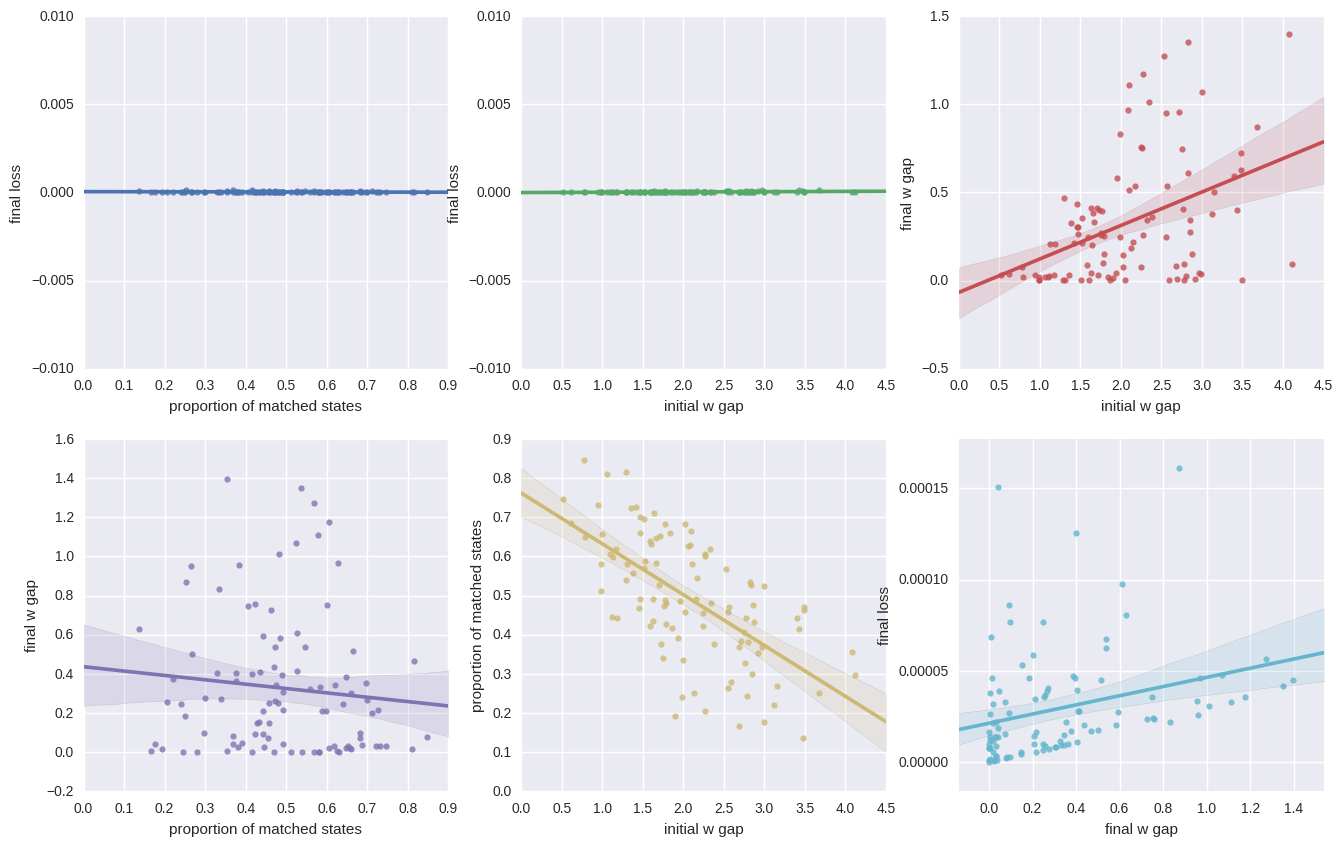

In [13]:
%%time
run_exp_and_plot(p=10,N=10000,q=10,h=1,build_func=arch.mlp_simple,num_epochs=100,verbose=False)

### Experiment 3 <a id='e3'></a>

Repeat experiment with no relu at last layer and fixed weights at last layer (3-layer)

CPU times: user 3min 10s, sys: 14.5 s, total: 3min 24s
Wall time: 2min 29s


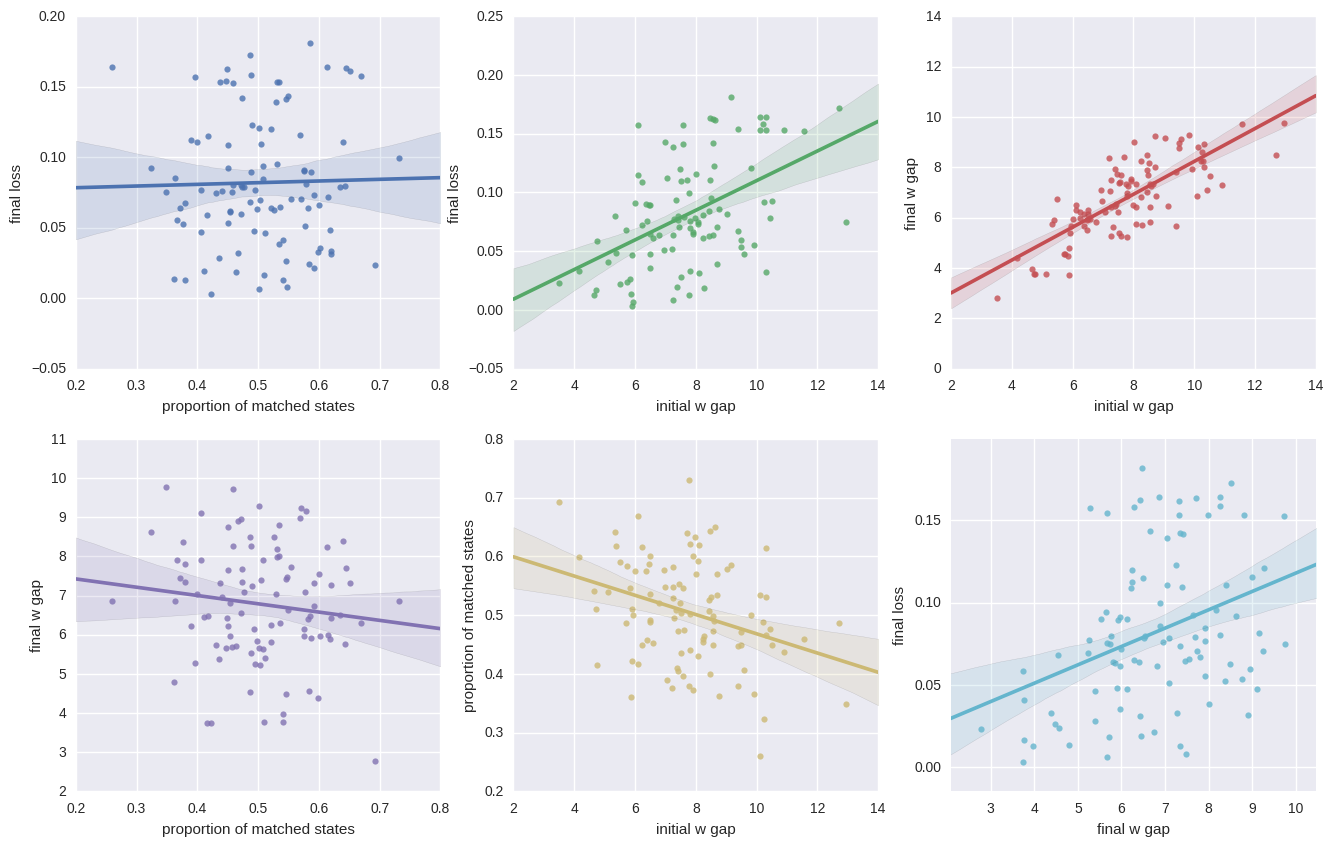

In [14]:
%%time
run_exp_and_plot(p=10,N=1000,q=10,h=3,
                 build_func=arch.mlp_noreluout_lastlayernottrainable,num_epochs=100,verbose=False)

CPU times: user 3min 10s, sys: 13.9 s, total: 3min 24s
Wall time: 2min 29s


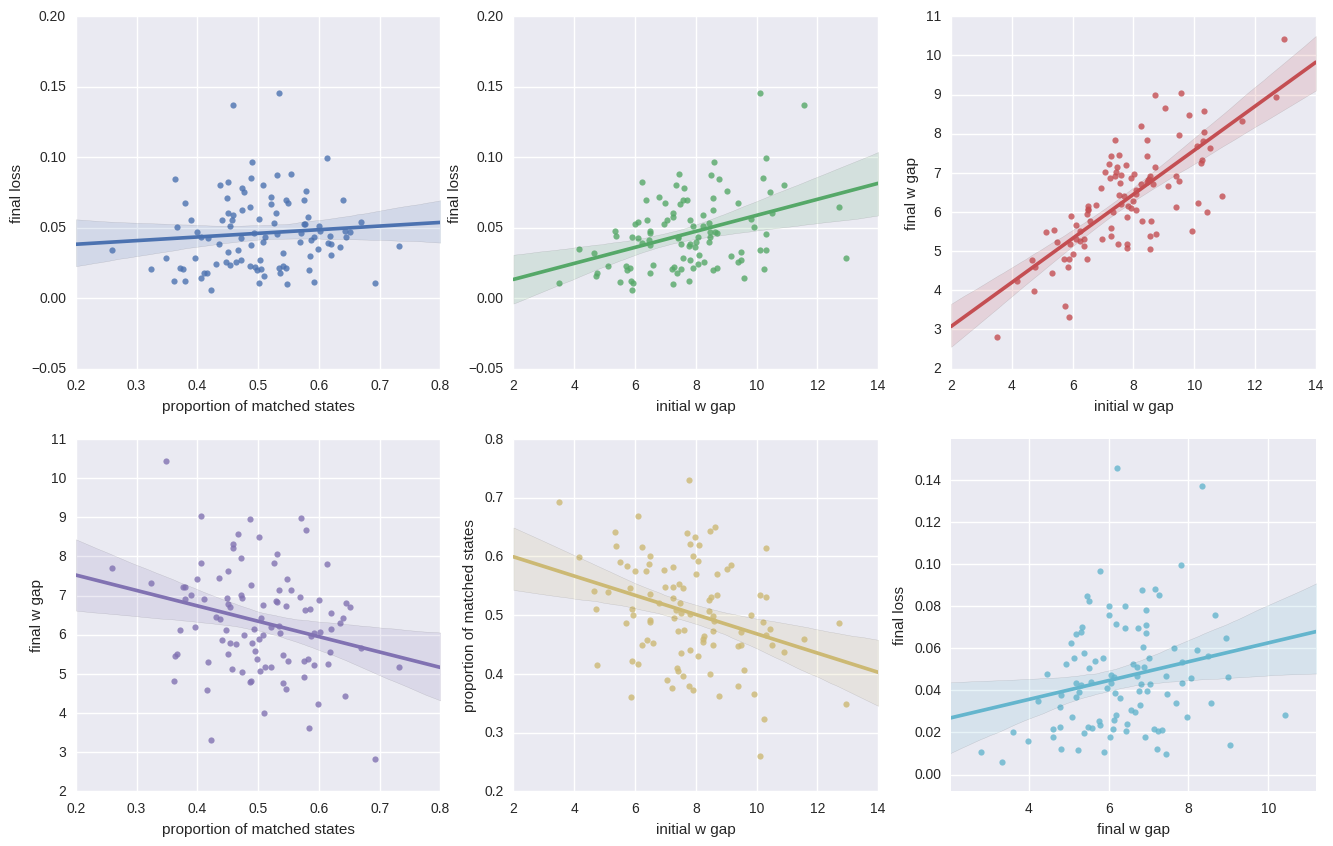

In [15]:
%%time
run_exp_and_plot(p=10,N=1000,q=10,h=3,build_func=arch.mlp_noreluout,num_epochs=100,verbose=False)

### Experiment 4 <a id='e4'></a>

Do slightly perturbed versions of $w^*$ converge to $w^*$?? (modify level of perturbation?)

CPU times: user 16min 52s, sys: 1min 19s, total: 18min 11s
Wall time: 14min 36s


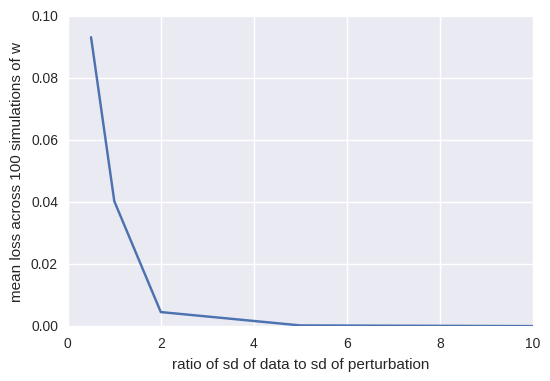

In [18]:
%%time

p = 10    # number of dimensions
N = 1000  # number of samples
q = 10    # rank of covariance matrix for generating samples
h = 3     # number of hidden units
build_func = arch.mlp
num_epochs = 100

input_dict = dict(p=p,h=h)
X,Y,hs,w = dl_utils.generate_data(N,q,input_dict,seed=0,build_func=build_func,get_hs=True)

list_init_perturb_w_true = [0.5,1.0,2.0,5.0,10.0]
losses = np.zeros((len(list_init_perturb_w_true),100))
for i,init_perturb_w_true in enumerate(list_init_perturb_w_true):

    logdir = './temp/initialize_with_perturbed_wtrue/perturbation%s_p%s_N%s_q%s_h%s_arch%s_numepochs%s/' \
             %(init_perturb_w_true,p,N,q,h,build_func.__name__,num_epochs)
    
    all_final_loss,all_final_w_gaps,all_initial_w_gaps,all_weights,all_prop_matched_states = \
        run_experiment(X,Y,w,input_dict,100,hs_true=hs,build_func=build_func,plot=False,
                       verbose=False,init_perturb_w_true=init_perturb_w_true,num_epochs=num_epochs,
                       logdir=logdir)
            
    losses[i,:] = all_final_loss
    
plt.plot(list_init_perturb_w_true,np.mean(losses,1))
plt.xlabel('ratio of sd of data to sd of perturbation')
plt.ylabel('mean loss across 100 simulations of w')

CPU times: user 4h 37min 39s, sys: 11min 26s, total: 4h 49min 5s
Wall time: 3h 50min 56s


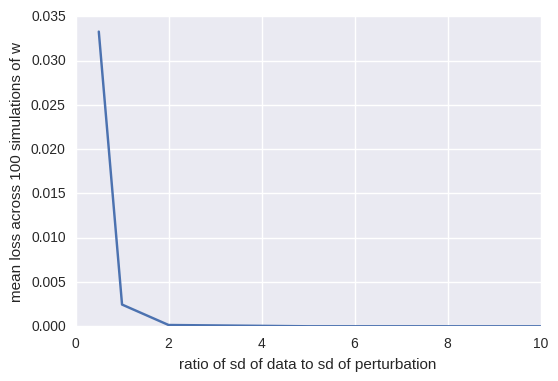

In [19]:
%%time

p = 10    # number of dimensions
N = 1000  # number of samples
q = 10    # rank of covariance matrix for generating samples
h = 3     # number of hidden units
build_func = arch.mlp
num_epochs = 1000

input_dict = dict(p=p,h=h)
X,Y,hs,w = dl_utils.generate_data(N,q,input_dict,seed=0,build_func=build_func,get_hs=True)

list_init_perturb_w_true = [0.5,1.0,2.0,5.0,10.0]
losses = np.zeros((len(list_init_perturb_w_true),100))
for i,init_perturb_w_true in enumerate(list_init_perturb_w_true):

    logdir = './temp/initialize_with_perturbed_wtrue/perturbation%s_p%s_N%s_q%s_h%s_arch%s_numepochs%s/' \
             %(init_perturb_w_true,p,N,q,h,build_func.__name__,num_epochs)
    
    all_final_loss,all_final_w_gaps,all_initial_w_gaps,all_weights,all_prop_matched_states = \
        run_experiment(X,Y,w,input_dict,100,hs_true=hs,build_func=build_func,plot=False,
                       verbose=False,init_perturb_w_true=init_perturb_w_true,num_epochs=num_epochs,
                       logdir=logdir)
            
    losses[i,:] = all_final_loss
    
plt.plot(list_init_perturb_w_true,np.mean(losses,1))
plt.xlabel('ratio of sd of data to sd of perturbation')
plt.ylabel('mean loss across 100 simulations of w')

### Experiment 5 <a id='e5'></a>

Try 2 layer net with 3 input nodes, 1 hidden node. Set $w^*$ to [1 -0.5 0.5], plot the obtained w*’s

CPU times: user 51min 33s, sys: 2min 3s, total: 53min 37s
Wall time: 43min 21s


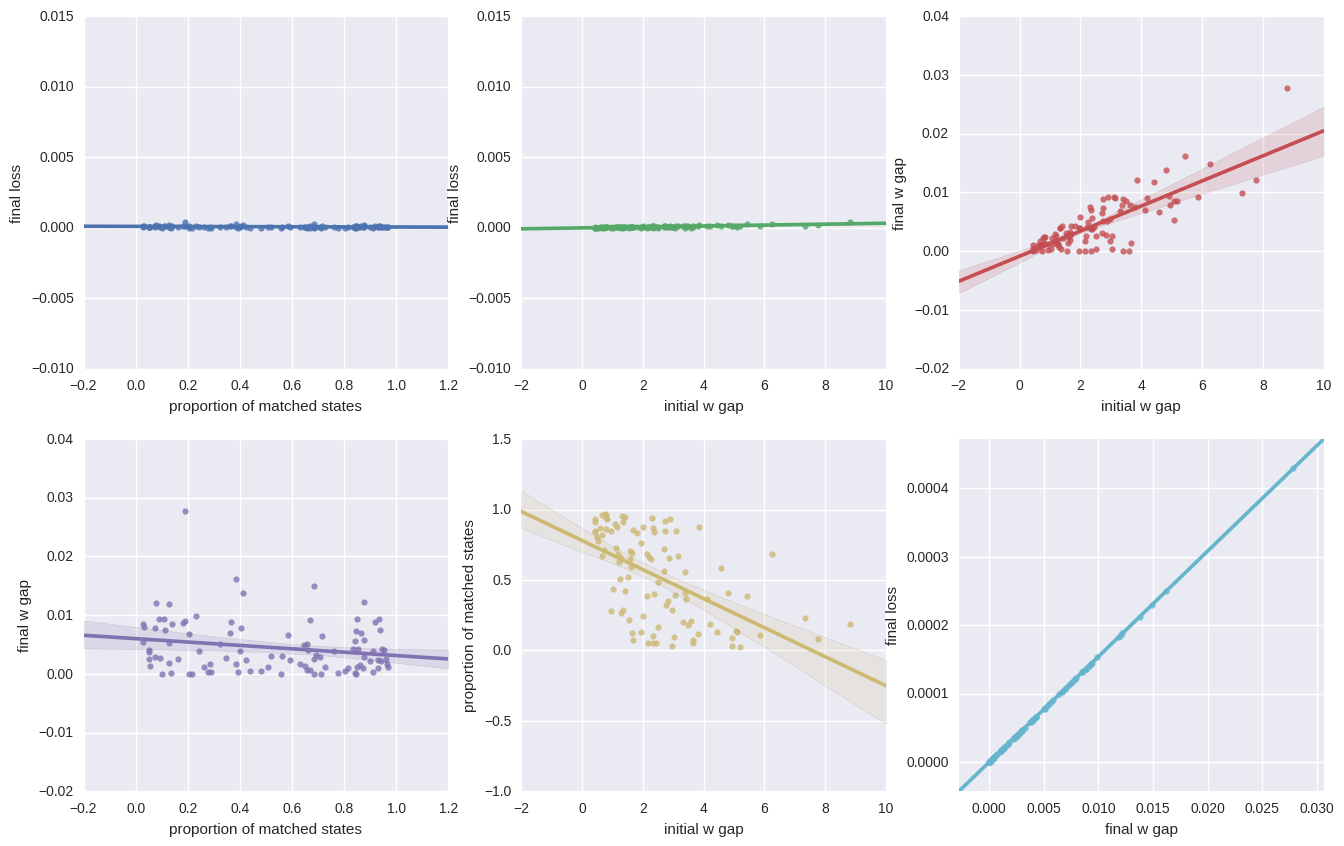

In [25]:
%%time

# Parameters
p = 3     # number of dimensions
N = 1000  # number of samples
q = 3     # rank of covariance matrix for generating samples
h = 1     # number of hidden units
build_func = arch.mlp_simple

input_dict = dict(p=p,h=h)
X = dl_utils.generate_X(N,q,input_dict)
w = {'weights': np.array([[1.0],[-0.5],[0.5]])}
Y = dl_utils.generate_output(X,w,input_dict,build_func=build_func,batch_size=100)
hs = dl_utils.get_hidden_states(X,input_dict,w,build_func=build_func)
logdir = './temp/p%s_N%s_q%s_h%s_arch%s_numepochs%s_set_wtrue_to_1_-0.5_0.5/' \
             %(p,N,q,h,build_func.__name__,num_epochs)
    
all_final_loss,all_final_w_gaps,all_initial_w_gaps,all_weights,all_prop_matched_states = \
    run_experiment(X,Y,w,input_dict,100,hs_true=hs,build_func=build_func,verbose=False,
                   num_epochs=1000,logdir=logdir)
    
generate_six_plots(all_prop_matched_states,all_final_loss,all_final_w_gaps,all_initial_w_gaps)

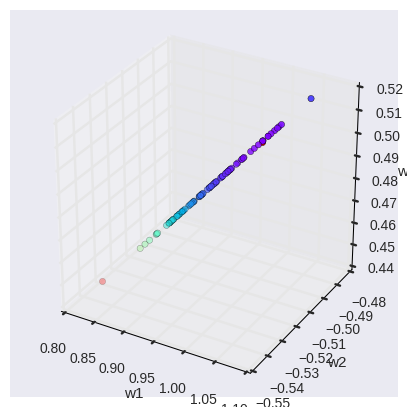

In [32]:
final_weights = np.array([i['weights'].reshape(-1) for i in all_weights])

plt.rcParams['image.cmap'] = 'rainbow'

# 3D Plot of W
fig = plt.figure(figsize=(5,5))
ax = plt.gca(projection='3d')

ax.scatter(final_weights[:,0], final_weights[:,1], final_weights[:,2],c=all_final_loss)
ax.scatter(w['weights'][0][0],w['weights'][1][0],w['weights'][2][0],c='r')
ax.set_xlabel('w1')
ax.set_ylabel('w2')
ax.set_zlabel('w3')
plt.show()

### Experiment 6 <a id='e6'></a>

Fix $w_2$ in $y = w_2 \mbox{relu}(w_1 x)$ case. Do we also see many initializations that lead to zero loss? Note that we use the true values of $w_2$ for this experiment.

CPU times: user 53min 58s, sys: 2min 12s, total: 56min 10s
Wall time: 44min 20s


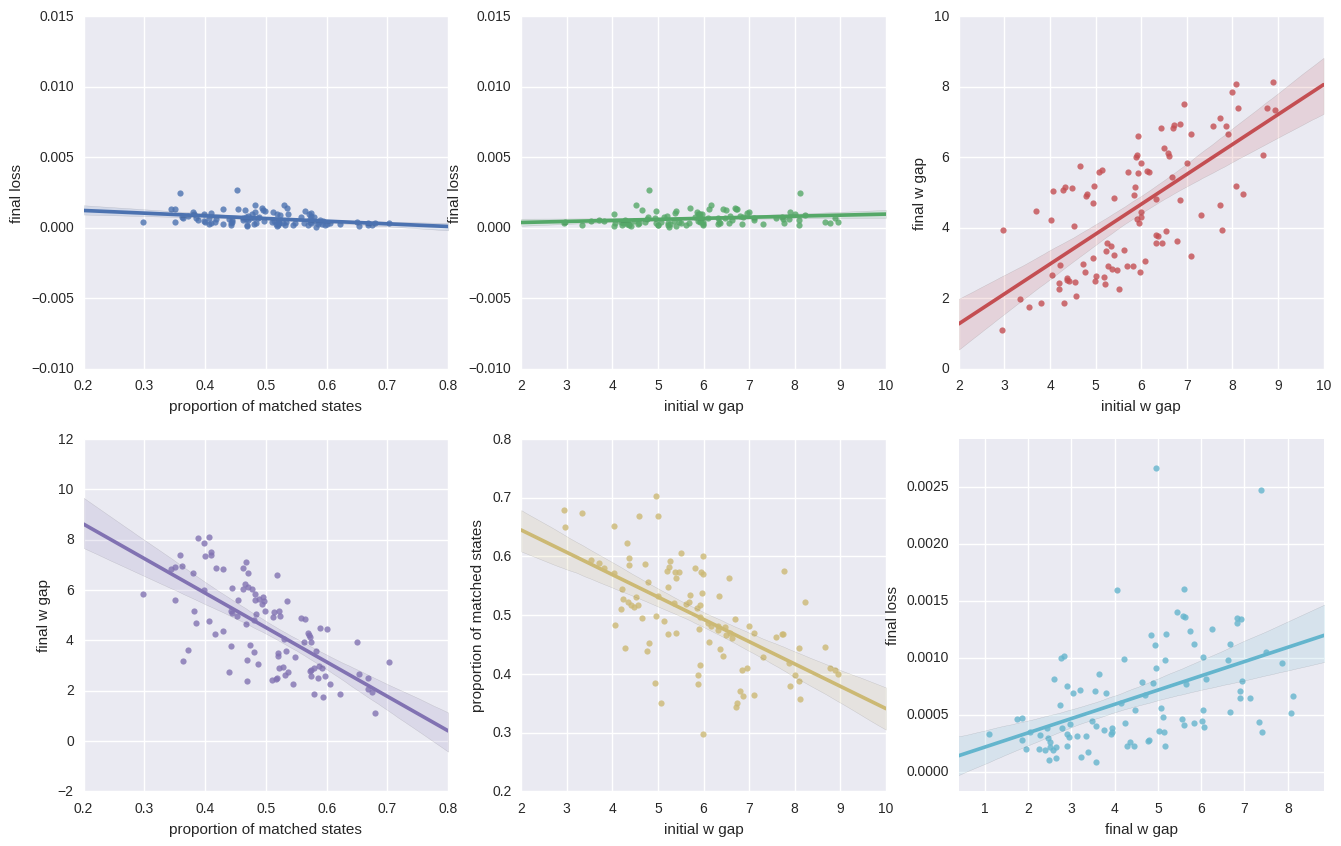

In [33]:
%%time

# Parameters
p = 10    # number of dimensions
N = 1000  # number of samples
q = 10    # rank of covariance matrix for generating samples
h = 3     # number of hidden units
build_func = arch.mlp_noreluout_lastlayernottrainable

input_dict = dict(p=p,h=h)
X,Y,hs,w = dl_utils.generate_data(N,q,input_dict,seed=0,build_func=build_func,get_hs=True)
logdir = './temp/p%s_N%s_q%s_h%s_arch%s_numepochs%s_fix_w2_to_true_w2/' \
             %(p,N,q,h,build_func.__name__,num_epochs)
    
all_final_loss,all_final_w_gaps,all_initial_w_gaps,all_weights,all_prop_matched_states = \
    run_experiment(X,Y,w,input_dict,100,hs_true=hs,build_func=build_func,plot=False,verbose=False,
                   num_epochs=1000,initial_weights={'weights2':w['weights2']},logdir=logdir)
    
generate_six_plots(all_prop_matched_states,all_final_loss,all_final_w_gaps,all_initial_w_gaps)